# Process Single Cell Profiles

**Gregory Way, 2019**

Load in specific columns:

  * `Cells_Neighbors_PercentTouching_Adjacent`
  * `Cells_Neighbors_NumberOfNeighbors_Adjacent` 
  
to visualize distributions across batches and cell lines.

## SQLite Tables

There are 4 tables in the database:

1. Cells
2. Cytoplasm
3. Nuclei
4. Image

They are to be merged together.

The first three can be merged by the following columns: `["TableNumber", "ImageNumber", "ObjectNumber"]`

The `Image` table can be merged by `["TableNumber", "ImageNumber"]`

In [1]:
import os
import glob
import pandas as pd
import sqlite3

from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
def get_sc_info(batch_id):
    conn = sqlite3.connect(sql_file_dict[batch_id])
    
    sc_cells_df = pd.read_sql_query(
        """
        select
        Cells_Neighbors_PercentTouching_Adjacent,
        Cells_Neighbors_NumberOfNeighbors_Adjacent
        from Cells
        """, conn)
    
    sc_cells_df.Cells_Neighbors_NumberOfNeighbors_Adjacent.hist(bins=12)
    plt.xlabel("NumberOfNeighbors_Adjacent - {}".format(batch_id))
    
    file = os.path.join("figures",
                        "single_cell_diagnostics",
                        "{}_adjacent.png".format(batch_id))
    plt.savefig(file, height = 4, width = 5)
    plt.show()
    plt.close()
    
    sc_cells_df.Cells_Neighbors_PercentTouching_Adjacent.hist(bins=12)
    plt.xlabel("NumberOfNeighbors_PercentTouching - {}".format(batch_id))
    
    file = os.path.join("figures",
                        "single_cell_diagnostics",
                        "{}_percenttouching.png".format(batch_id))
    plt.savefig(file, height = 4, width = 5)
    plt.show()
    plt.close()
    
    # Seaborn Joint Plot
    g = sns.jointplot("Cells_Neighbors_PercentTouching_Adjacent",
                      "Cells_Neighbors_NumberOfNeighbors_Adjacent",
                      data=sc_cells_df,
                      kind="hex")
    
    file = os.path.join("figures",
                        "single_cell_diagnostics",
                        "{}_neighbor_relationship.png".format(batch_id))
    plt.savefig(file, height = 4, width = 5)
    plt.show()
    plt.close()

In [4]:
os.makedirs(os.path.join("figures", "single_cell_diagnostics"), exist_ok=True)
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)

## Step 0 - Load Constants and Generate Objects

In [5]:
batches = ["BR00103267", "BR00103268"]

cell_cols = ["TableNumber", "ImageNumber", "ObjectNumber"]
image_cols = ["TableNumber", "ImageNumber"]

bucket_dir = os.path.join("..", "..", "..", "..", "..", "..", "bucket")
backend_dir = os.path.join("projects", "2018_06_05_cmQTL", "workspace", "backend")
batch_dir = os.path.join(bucket_dir, backend_dir, "2019_05_13_Batch2")

sql_file_dict = {
    x: os.path.join(batch_dir, x, "{}.sqlite".format(x))
    for x in batches
}

sql_file_dict

{'BR00103267': '../../../../../../bucket/projects/2018_06_05_cmQTL/workspace/backend/2019_05_13_Batch2/BR00103267/BR00103267.sqlite',
 'BR00103268': '../../../../../../bucket/projects/2018_06_05_cmQTL/workspace/backend/2019_05_13_Batch2/BR00103268/BR00103268.sqlite'}

In [6]:
# Load example data for selected features
file = os.path.join(batch_dir, batches[0], 'BR00103267_normalized_variable_selected.csv')
example_df = pd.read_csv(file, sep=',')

cp_features = example_df.loc[:, ~example_df.columns.str.startswith("Metadata_")].columns.tolist()
print(len(cp_features))

example_df.head(2)

589


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,...,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
0,BR00103267,A01,BR00103267,cmQTL1-4_mt,A01,5000,A,6,-0.194779,0.682061,...,1.867574,-0.295660,2.067796,-0.704951,1.402976,3.063689,2.954758,0.218780,2.926116,3.340355
1,BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6,-0.834432,-2.867988,...,1.163408,0.915729,0.581761,-0.919340,1.817793,1.057007,1.533685,-1.050026,0.872220,1.716821


In [7]:
use_cols = cell_cols + ["Metadata_Well", "Metadata_Plate"] + cp_features
len(use_cols)

594

## Step 1 - Visualize Single Cell Relationships

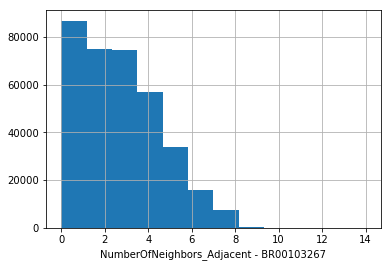

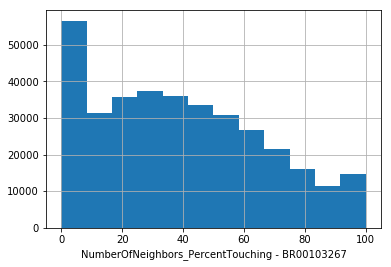

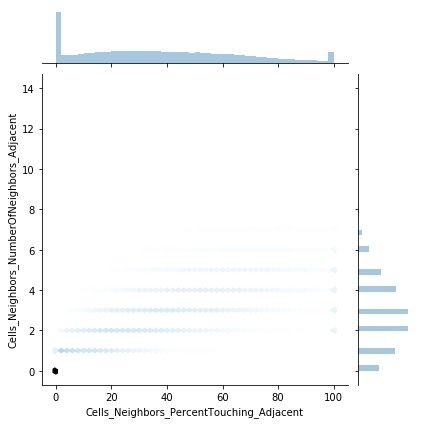

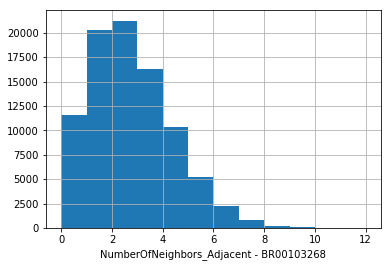

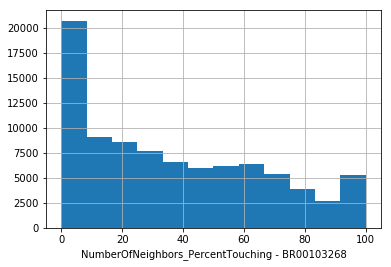

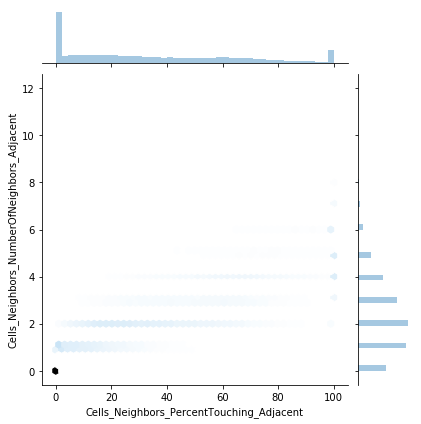

In [8]:
# Generate and save plots
for batch in batches:
    get_sc_info(batch)

## Step 2 - Count how many cells per well and single cell type

In [9]:
cell_count_list = []
for batch_id in batches:
    conn = sqlite3.connect(sql_file_dict[batch_id])
    
    # Read in single cell profiles
    sc_cells_df = pd.read_sql_query(
        """
        select
        TableNumber,
        ImageNumber,
        ObjectNumber,
        Cells_Neighbors_NumberOfNeighbors_Adjacent
        from Cells
        """, conn).merge(
        pd.read_sql_query(
            """
            select
            TableNumber,
            ImageNumber,
            Metadata_Well
            from Image
            """, conn),
        left_on=image_cols,
            right_on=image_cols,
            how='left'
        )

    # Get Cell Counts
    total_count_df = pd.DataFrame(
        sc_cells_df.groupby("Metadata_Well")
        ['ObjectNumber']
        .count()
        .reset_index()
        .rename({"ObjectNumber": "cell_count"}, axis='columns')
        .assign(batch_id=batch_id,
                sc_type="all")
    )
    cell_count_list.append(total_count_df)
    
    isolated_count_df = pd.DataFrame(
        sc_cells_df
        .query("Cells_Neighbors_NumberOfNeighbors_Adjacent == 0")
        .groupby("Metadata_Well")
        ['ObjectNumber']
        .count()
        .reset_index()
        .rename({"ObjectNumber": "cell_count"}, axis='columns')
        .assign(batch_id=batch_id,
                sc_type="isolated")
    )
    cell_count_list.append(isolated_count_df)
    
    colony_count_df = pd.DataFrame(
        sc_cells_df
        .query("Cells_Neighbors_NumberOfNeighbors_Adjacent >= 4")
        .groupby("Metadata_Well")
        ['ObjectNumber']
        .count()
        .reset_index()
        .rename({"ObjectNumber": "cell_count"}, axis='columns')
        .assign(batch_id=batch_id,
                sc_type="colony")
    )
    cell_count_list.append(colony_count_df)

In [10]:
cell_count_df = pd.concat(cell_count_list)

file = os.path.join("results", "well_cell_counts.tsv")
cell_count_df.to_csv(file, sep='\t')

## Step 3 - Extract Single Cell Profiles

In [11]:
for batch_id in batches:
    conn = sqlite3.connect(sql_file_dict[batch_id])
    
    # Read in single cell profiles
    sc_cells_df = pd.read_sql_query("""
        select *
        from Cells
        where Cells_Neighbors_NumberOfNeighbors_Adjacent == 0
        """, conn)

    # Load and Merge Single Cell Data
    sc_cells_df = (
        sc_cells_df
        .merge(
            pd.read_sql_query("""
                select *
                from Cytoplasm
                """, conn),
            left_on=cell_cols,
            right_on=cell_cols,
            how='left'
        )
        .merge(
            pd.read_sql_query("""
                select *
                from Nuclei
                """, conn),
            left_on=cell_cols,
            right_on=cell_cols,
            how='left'
        )
        .merge(
            pd.read_sql_query("""
                select *
                from Image
                """, conn),
            left_on=image_cols,
            right_on=image_cols,
            how='left'
        )
    ).loc[:, use_cols]

    # Write out the file to disk
    file = os.path.join("data", "{}_single_cell_isolated_profiles.tsv.gz".format(batch_id))
    sc_cells_df.to_csv(file, sep='\t', index=False)
    
    del sc_cells_df
    
    colony_cells_df = pd.read_sql_query("""
        select *
        from Cells
        where Cells_Neighbors_NumberOfNeighbors_Adjacent >= 4
        """, conn)

    # Load Single Cell Data
    colony_cells_df = (
        colony_cells_df.merge(
            pd.read_sql_query("""
                select *
                from Cytoplasm
                """, conn),
            left_on=cell_cols,
            right_on=cell_cols,
            how='left'
        ).merge(
            pd.read_sql_query("""
                select *
                from Nuclei
                """, conn),
            left_on=cell_cols,
            right_on=cell_cols,
            how='left'
        ).merge(
            pd.read_sql_query("""
                select *
                from Image
                """, conn),
            left_on=image_cols,
            right_on=image_cols,
            how='left'
        )
    ).loc[:, use_cols]
    
    file = os.path.join("data", "{}_single_cell_colony_profiles.tsv.gz".format(batch_id))
    colony_cells_df.to_csv(file, sep='\t', index=False)
    
    del colony_cells_df